In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import time
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
plt.style.use("ggplot")
plt.rcParams["font.size"] = 13

## Horner法で多項式の値を求める

`coefs`: `[0次の係数, 1次の係数, ..., 最高次の係数]`

In [2]:
def get_poly_value(coefs, x):
    value = 0.0
    size = len(coefs)
    for i in range(size):
        if i == 0:
            value += coefs[size-i-1]
        else:
            value = value * x + coefs[size-i-1]
            
    return value

In [3]:
get_poly_value([2, 5, 3], -1)

0.0

## 素直な解法

In [4]:
def get_poly_product(f_coefs, g_coefs):
    """
    Parameters:
        f_coefs: array_like. fの係数のリスト. [0次の係数, 1次の係数, ..., 最高次の係数]
        g_coefs: array_like. gの係数のリスト. [0次の係数, 1次の係数, ..., 最高次の係数]
    Returns:
        h_coefs: ndarray. h=fgの係数のリスト. [0次の係数, 1次の係数, ..., 最高次の係数]
    """
    f_size, g_size = len(f_coefs), len(g_coefs)
    h_coefs = np.zeros([f_size+g_size-1], dtype=float)
    
    for i in range(f_size):
        for j in range(g_size):
            h_coefs[i+j] += f_coefs[i] * g_coefs[j]
            
    return h_coefs

In [5]:
get_poly_product([3, 2, 1], [4, 3])

array([12., 17., 10.,  3.])

## FFTを使った解法

### FFTにライブラリを使用

In [6]:
def get_poly_product_fft(f_coefs, g_coefs):
    """
    Parameters:
        f_coefs: array_like. fの係数のリスト. [0次の係数, 1次の係数, ..., 最高次の係数]
        g_coefs: array_like. gの係数のリスト. [0次の係数, 1次の係数, ..., 最高次の係数]
    Returns:
        h_coefs: ndarray. h=fgの係数のリスト. [0次の係数, 1次の係数, ..., 最高次の係数]
    """
    h_size = len(f_coefs) + len(g_coefs) - 1
    h_fft_coefs = np.fft.fft(f_coefs, n=h_size) * np.fft.fft(g_coefs, n=h_size)
    h_coefs = np.fft.ifft(h_fft_coefs)
    
    return np.real(h_coefs)


In [7]:
get_poly_product_fft([3, 2, 1], [4, 3])

array([12., 17., 10.,  3.])

## 速度比較

$n = 2, 4, 8, \ldots, 2^{15}$次多項式同士の積を計算する. 

In [8]:
def get_mean_time(func, *array):
    time_list = np.zeros([len(array[0])])
    for i, a in enumerate(zip(*array)):
        start_time = time.time()
        func(*a)
        time_list[i] = time.time() - start_time
        
    # remove slowest/fastest time
    time_list.sort()
    
    return np.mean(time_list[1:-1])


In [9]:
n_list = [2 ** i for i in range(1, 15+1)]
sample_size = 20
random_state = np.random.RandomState(2018)

n_size = len(n_list)
simple_mean_time, fft_mean_time = [], []

for i, n in enumerate(n_list):
    print("Current n = {}".format(n))
    sample_f_coefs = random_state.randint(low=-100, high=100, size=(sample_size, n))
    sample_g_coefs = random_state.randint(low=-100, high=100, size=(sample_size, n))
    
    # simple
    if n < 3000:
        t = get_mean_time(get_poly_product, sample_f_coefs, sample_g_coefs)
        simple_mean_time.append(t)
    
    # FFT
    t = get_mean_time(get_poly_product_fft, sample_f_coefs, sample_g_coefs)
    fft_mean_time.append(t)


Current n = 2
Current n = 4
Current n = 8
Current n = 16
Current n = 32
Current n = 64
Current n = 128
Current n = 256
Current n = 512
Current n = 1024
Current n = 2048
Current n = 4096
Current n = 8192
Current n = 16384
Current n = 32768


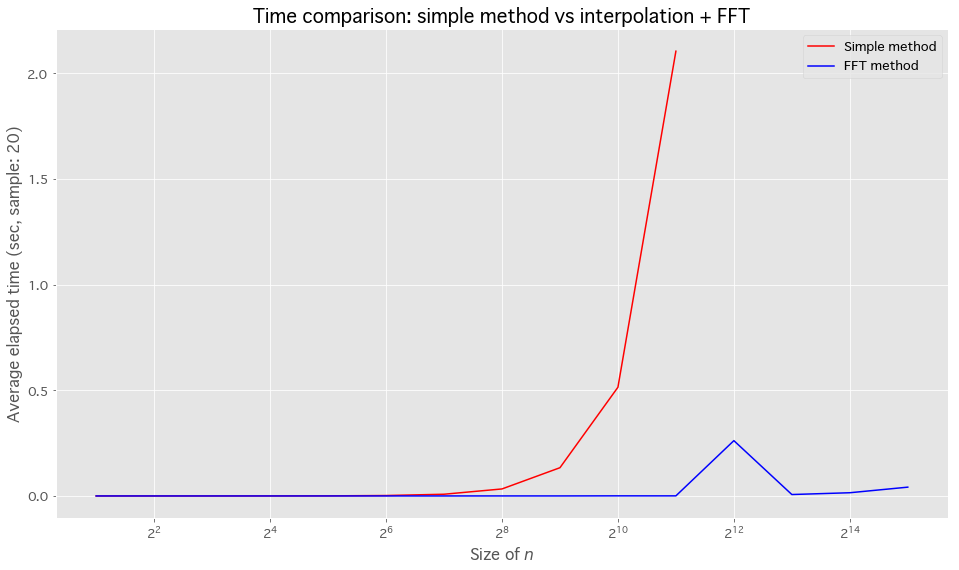

In [10]:
fig = plt.figure(figsize=(16, 9))
plt.plot(n_list[:len(simple_mean_time)], simple_mean_time, color="red", label="Simple method")
plt.plot(n_list, fft_mean_time, color="blue", label="FFT method")
plt.xscale("log", basex=2)
plt.title("Time comparison: simple method vs interpolation + FFT")
plt.xlabel(r"Size of $n$")
plt.ylabel("Average elapsed time (sec, sample: {:d})".format(sample_size))
plt.legend()
plt.show()